In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="white")
df = pd.read_csv("data_cleaned.csv")

In [2]:
df.head()

,patient,id,age,eventdeath,survival,timerecurrence,chemo,hormonal,amputation,histtype,...,contig36312_rc,contig38980_rc,nm_000853,nm_000854,nm_000860,contig29014_rc,contig46616_rc,nm_000888,nm_000898,af067420
0,s122,18,43,False,14.817248,14.817248,False,False,True,1,...,0.591103,-0.355018,0.373644,-0.760690,-0.164025,-0.038726,0.237856,-0.087631,-0.369153,0.153795
1,s123,19,48,False,14.261465,14.261465,False,False,False,1,...,-0.199829,-0.001635,-0.062922,-0.682204,-0.220934,-0.100088,-0.466537,-0.231547,-0.643019,-0.014098
2,s124,20,38,False,6.644764,6.644764,False,False,False,1,...,0.328736,-0.047571,0.084228,-0.695950,-0.402840,-0.099965,0.110155,-0.114298,0.258495,-0.198911
3,s125,21,50,False,7.748118,7.748118,False,True,False,1,...,0.648861,-0.039088,0.182182,-0.524640,0.037320,-0.167688,-0.016790,-0.285344,-0.251188,0.862710
4,s126,22,38,False,6.436687,6.318960,False,False,True,1,...,-0.287538,-0.286893,0.057082,-0.565021,-0.105632,-0.108148,-0.405853,-0.053601,-0.677072,0.134160


In [3]:
df.eventdeath = df.eventdeath.apply(lambda x: 1 if x == True else 0)

In [4]:
print("Mean age: " + "%.3f" %np.mean(df["age"]))
print("Mean tumour grade: " + "%.3f" %np.mean(df["grade"]))
print("Mean tumour diameter: " + "%.3f" %np.mean(df["diam"]))

Mean age: 44.048
Mean tumour grade: 2.129
Mean tumour diameter: 22.529


In [5]:
subset = df.loc[:,:"barcode"]

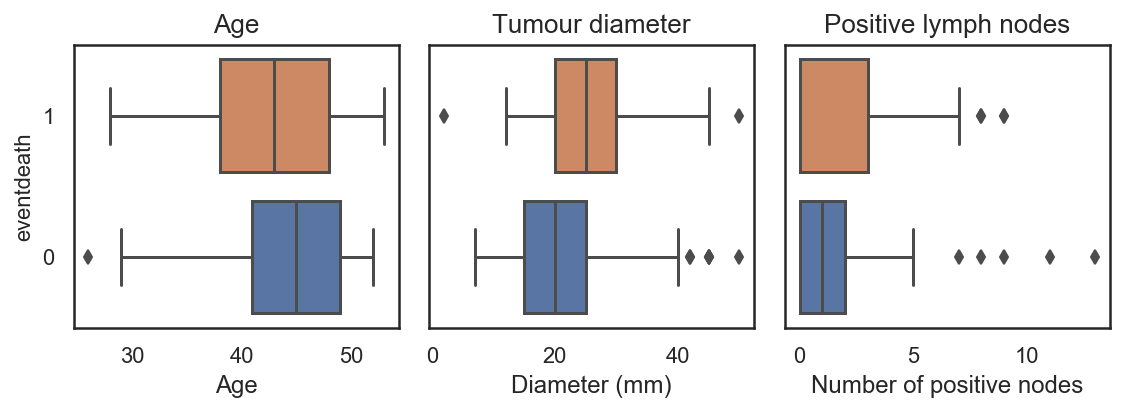

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(8,3), sharey=True)

pal = [sns.color_palette()[0], sns.color_palette()[1]]

sns.boxplot(x="age", y="eventdeath", orient="h", data=subset, ax=ax1, palette=pal)
sns.boxplot(x="diam", y="eventdeath", orient="h", data=subset, ax=ax2, palette=pal)
sns.boxplot(x="posnodes", y="eventdeath", orient="h", data=subset, ax=ax3, palette=pal)

ax1.set_title("Age", size=13)
ax1.invert_yaxis()
ax1.set_ylabel("eventdeath", size=11)
ax1.set_xlabel("Age")
ax2.set_title("Tumour diameter", size=13)
ax2.set_ylabel("")
ax2.set_xlabel("Diameter (mm)")
ax3.set_title("Positive lymph nodes", size=13)
ax3.set_ylabel("")
ax3.set_xlabel("Number of positive nodes")

plt.tight_layout()
plt.savefig("visuals/EDA_clinical_features.jpeg")
plt.show()

In [7]:
from scipy.stats import pearsonr

clinical_corrs=pd.DataFrame(columns=["Variable", "Correlation coefficient", "P value"])
i=0
for var in ["age", "diam", "posnodes"]:
    corr, p = pearsonr(subset[var], subset["eventdeath"])
    clinical_corrs.loc[i, "Variable"] = var
    clinical_corrs.loc[i, "Correlation coefficient"] = corr
    clinical_corrs.loc[i, "P value"] = p
    i+=1

clinical_corrs

,Variable,Correlation coefficient,P value
0,age,-0.147643,0.0148035
1,diam,0.215344,0.000347234
2,posnodes,0.0917786,0.131077


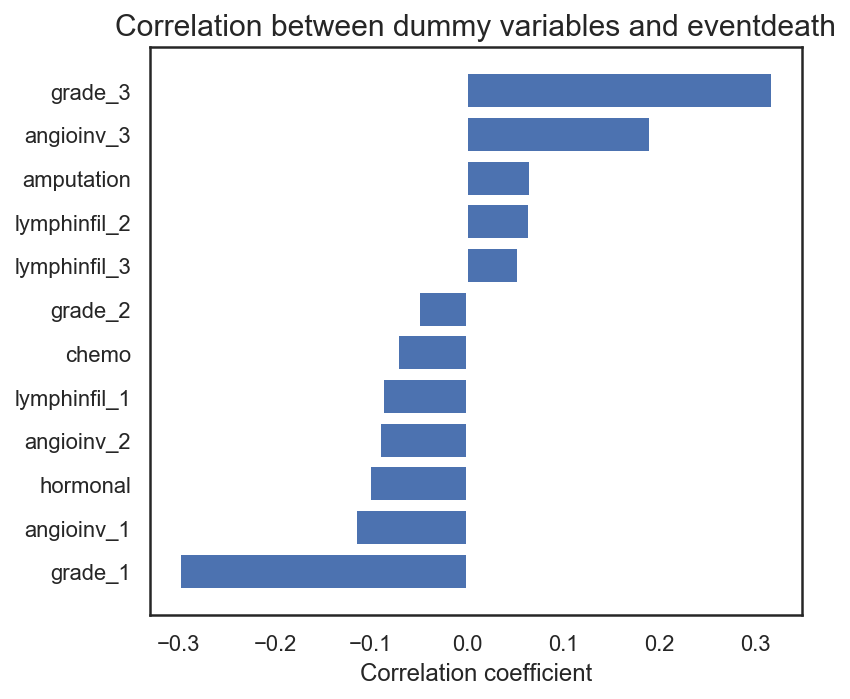

In [9]:
clinical_var = ["age", "diam", "posnodes", "survival", "timerecurrence", "grade", "angioinv", "lymphinfil", "chemo", "hormonal", "amputation"]
subset2 = df.loc[:,clinical_var]
dummied = pd.get_dummies(subset2, columns=["grade", "angioinv", "lymphinfil"])

#create a dataframe of correlations
dummied_corrs=pd.DataFrame(columns=["Variable", "Correlation coefficient", "P value"])
i=0
for var in dummied.loc[:,"chemo":].columns:
    corr, p = pearsonr(dummied[var], subset["eventdeath"])
    dummied_corrs.loc[i, "Variable"] = var
    dummied_corrs.loc[i, "Correlation coefficient"] = corr
    dummied_corrs.loc[i, "P value"] = p
    i+=1

#visualise
fig, ax = plt.subplots(figsize=(6,5))
dummied_corrs = dummied_corrs.sort_values("Correlation coefficient", ascending=True)
labels = dummied_corrs["Variable"]
y_pos = np.arange(len(labels))
ax.barh(y_pos, dummied_corrs["Correlation coefficient"])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation between dummy variables and eventdeath", size=15)
plt.tight_layout()
plt.savefig("visuals/EDA_dummy_clinical.jpeg")
plt.show()

In [10]:
no_treatment = subset[(subset["chemo"]==False) & (subset["amputation"]==False) & (subset["hormonal"]==False)]
print("Number of patients who had no treatment: " + str(np.shape(no_treatment)[0]))
print("Proportion of death in this group: " + ("%.3f" %np.mean(no_treatment["eventdeath"])))
print("Baseline comparison:")
print(df["eventdeath"].value_counts()/df["eventdeath"].count())

Number of patients who had no treatment: 87
Proportion of death in this group: 0.241
Baseline comparison:
0    0.716912
1    0.283088
Name: eventdeath, dtype: float64


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pickle

#assign X and y
y = subset["eventdeath"]
X = dummied.copy() #use dataframe of dummied predictive clinical features 
X = StandardScaler().fit_transform(X)

#and an X without time related features as these have no predictive power for new patients
X_predictive = dummied.copy()
del X_predictive["survival"]
del X_predictive["timerecurrence"]
predictive_df = X_predictive.copy()
X_predictive = StandardScaler().fit_transform(X_predictive)

#baseline accuracy is 72%
print(subset["eventdeath"].value_counts()/subset["eventdeath"].count())

0    0.716912
1    0.283088
Name: eventdeath, dtype: float64


# SVM

In [12]:
from sklearn import svm

params = {
    "C": np.logspace(-2,2,20),
    "kernel": ["linear", "poly", "rbf"],
    "gamma": np.logspace(-5,2,20),
    "degree": [3]
}
#all features
clf = svm.SVC(probability=True)
gridsearch = GridSearchCV(clf, params, n_jobs=-1, cv=4)
gridsearch.fit(X, y)

#predictive features
clf = svm.SVC(probability=True)
pred_gridsearch = GridSearchCV(clf, params, n_jobs=-1, cv=4)
pred_gridsearch.fit(X_predictive, y)
pickle.dump(pred_gridsearch.best_estimator_, open("clinical_models/SVM.pkl", 'wb'))

print("baseline accuracy: " + str(0.717))
print("SVM accuracy: " + str(gridsearch.best_score_))
print("SVM accuracy using only predictive features: " + str(pred_gridsearch.best_score_))
print("best params using predictive features: " + str(pred_gridsearch.best_params_))

baseline accuracy: 0.717
SVM accuracy: 0.8823529411764706
SVM accuracy using only predictive features: 0.7426470588235294
best params using predictive features: {'C': 1.2742749857031335, 'degree': 3, 'gamma': 0.02069138081114788, 'kernel': 'rbf'}


# KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors" : [1,5,10,15,20,25,30,35,40],
    "weights" : ["uniform" , "distance"]
}
#all features
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, params, n_jobs=-1, cv=4)
gridsearch.fit(X, y)

#predictive features
knn = KNeighborsClassifier()
pred_gridsearch = GridSearchCV(knn, params, n_jobs=-1, cv=4)
pred_gridsearch.fit(X_predictive, y)
pickle.dump(pred_gridsearch.best_estimator_, open("clinical_models/KNN.pkl", 'wb'))

print("baseline accuracy: " + str(0.717))
print("KNN accuracy: " + str(gridsearch.best_score_))
print("KNN accuracy using only predictive features: " + str(pred_gridsearch.best_score_))
print("best params using predictive features: " + str(pred_gridsearch.best_params_))

baseline accuracy: 0.717
KNN accuracy: 0.8272058823529411
KNN accuracy using only predictive features: 0.724264705882353
best params using predictive features: {'n_neighbors': 25, 'weights': 'uniform'}


# Gene Expression


In [15]:
genes = df.loc[:,"esr1":]

In [16]:
y = subset["eventdeath"]
X = genes.copy() #use dataframe of genes subset 
X = StandardScaler().fit_transform(X)

# SVM

In [17]:
from itertools import combinations

#generate 7 boundaries to test and dataframes for each
boundaries = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35]
thresh_1=genes.copy()
thresh_2=genes.copy()
thresh_3=genes.copy()
thresh_4=genes.copy()
thresh_5=genes.copy()
thresh_6=genes.copy()
thresh_7=genes.copy()
genes_dfs = [thresh_1, thresh_2, thresh_3, thresh_4, thresh_5, thresh_6, thresh_7]

#add feature interactions above the boundary to each
for combination in combinations(genes.columns,2):
    first, second = combination[0], combination[1]
    new_array = genes[first]*genes[second]
    corr, p = pearsonr(new_array, y)
    for bound, df in zip(boundaries, genes_dfs):
        upper = bound
        lower = -bound
        if corr < lower or corr > upper:
            df[combination] = new_array

In [18]:
thresh_2.to_csv("threshold_0.225.csv", sep=",")
thresh_3.to_csv("threshold_0.25.csv", sep=",")


In [19]:
lower_thresh = pd.read_csv("threshold_0.225.csv", sep=",", index_col="Unnamed: 0")
lower_best_C = 1.374
higher_thresh = pd.read_csv("threshold_0.25.csv", sep=",", index_col="Unnamed: 0")
higher_best_C = 9.237

In [20]:
from sklearn.metrics import classification_report

lower_X = StandardScaler().fit_transform(lower_thresh)
lower_lasso = LogisticRegression(C=lower_best_C, penalty="l1", solver="liblinear")
lower_model = lower_lasso.fit(lower_X, y)
lower_predictions = cross_val_predict(lower_lasso, lower_X, y, cv=4)
print("Report at lower threshold of correlation coefficient = 0.225")
print(classification_report(y, lower_predictions))

higher_X = StandardScaler().fit_transform(higher_thresh)
higher_lasso = LogisticRegression(C=higher_best_C, penalty="l1", solver="liblinear")
higher_model = higher_lasso.fit(higher_X, y)
higher_predictions = cross_val_predict(higher_lasso, higher_X, y, cv=4)
print("Report at higher threshold of correlation coefficient = 0.25")
print(classification_report(y, higher_predictions))

Report at lower threshold of correlation coefficient = 0.225
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       195
           1       0.70      0.74      0.72        77

    accuracy                           0.83       272
   macro avg       0.79      0.81      0.80       272
weighted avg       0.84      0.83      0.84       272

Report at higher threshold of correlation coefficient = 0.25
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       195
           1       0.68      0.81      0.74        77

    accuracy                           0.84       272
   macro avg       0.80      0.83      0.81       272
weighted avg       0.85      0.84      0.84       272



In [21]:
from sklearn import svm
params = {
    "C": np.logspace(-2,2,15),
    "kernel": ["linear", "poly", "rbf"],
    "gamma": np.logspace(-5,2,15),
    "degree": [3]
}
#using just gene features
clf = svm.SVC(probability=True)
gridsearch = GridSearchCV(clf, params, n_jobs=-1, cv=4)
gridsearch.fit(X, y)
pickle.dump(gridsearch.best_estimator_, open("gene_models/SVM.pkl", 'wb'))

#using genes and feature interactions
clf = svm.SVC(probability=True)
gridsearch_int = GridSearchCV(clf, params, n_jobs=-1, cv=4)
gridsearch_int.fit(higher_X, y)
pickle.dump(gridsearch_int.best_estimator_, open("gene_models/SVM_int.pkl", 'wb'))

print("baseline accuracy: " + str(0.717))
print("SVM accuracy: " + str(gridsearch.best_score_))
print("best params: " + str(gridsearch.best_params_))
print("SVM accuracy with added feature interactions: " + str(gridsearch_int.best_score_))
print("best params with feature interactions: " + str(gridsearch_int.best_params_))

baseline accuracy: 0.717
SVM accuracy: 0.7352941176470589
best params: {'C': 3.727593720314938, 'degree': 3, 'gamma': 0.00031622776601683794, 'kernel': 'rbf'}
SVM accuracy with added feature interactions: 0.8419117647058824
best params with feature interactions: {'C': 26.826957952797247, 'degree': 3, 'gamma': 3.1622776601683795e-05, 'kernel': 'rbf'}


# KNN


In [22]:
params = {
    "n_neighbors" : [1,5,10,15,20,25,30,35,40],
    "weights" : ["uniform" , "distance"]
}
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, params, n_jobs=-1, cv=4)
gridsearch.fit(X, y)
pickle.dump(gridsearch.best_estimator_, open("gene_models/KNN.pkl", 'wb'))

print("baseline accuracy: " + str(0.717))
print("KNN accuracy: " + str(gridsearch.best_score_))
print("best params: " + str(gridsearch.best_params_))

baseline accuracy: 0.717
KNN accuracy: 0.724264705882353
best params: {'n_neighbors': 35, 'weights': 'uniform'}


# Using clinical variables and gene expression

In [24]:
combined = pd.concat((predictive_df, higher_thresh), axis=1)
X = StandardScaler().fit_transform(combined)
y = subset["eventdeath"]

In [25]:
from sklearn import svm
params = {
    "C": np.logspace(-2,2,15),
    "kernel": ["linear", "poly", "rbf"],
    "gamma": np.logspace(-5,2,15),
    "degree": [3]
}
clf = svm.SVC(probability=True)
gridsearch = GridSearchCV(clf, params, n_jobs=-1, cv=4)
gridsearch.fit(X, y)
pickle.dump(gridsearch.best_estimator_, open("combined_models/SVM.pkl", 'wb'))

print("baseline accuracy: " + str(0.717))
print("SVM accuracy: " + str(gridsearch.best_score_))
print("best params: " + str(gridsearch.best_params_))

baseline accuracy: 0.717
SVM accuracy: 0.8455882352941176
best params: {'C': 100.0, 'degree': 3, 'gamma': 1e-05, 'kernel': 'rbf'}
